In [1]:
#Imports
import base64
import sys
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import pyvisa
import logging
import numpy as np
from time import sleep
from toptica.lasersdk.client import Client, SerialConnection, UserLevel, Subscription, Timestamp, SubscriptionValue

In [2]:
#Configuration Variables
log_file = "../Data/Sensitivity_140GHz_Test/Logs/f_vs_vlockin_140Ghz_secondrun_sens2.log" #name of log file
plot_file = '../Data/Sensitivity_140GHz_Test/Plots/f_vs_vlockin_140Ghz_secondrun_sens2.png' #name of plot file
csv_file = '../Data/Sensitivity_140GHz_Test/Tables/f_vs_vlockin_140Ghz_secondrun_sens2.csv' #name of csv file
warm_up_time = 30 #In seconds, how long PROWLS should wait at desired settings before taking data
power_down = False #True or False, if PROWLS should power down after data acquisition
lockin_address = 'GPIB::8::INSTR' #connection to DLC Smart
dlc_connection_port = 'COM3' #connection to lock-in amplifier
bias_frequency = 1000 #in Hz, the bias frequency of DLC Smart and the lock-in amplifier
sensitivity_setting = 19 #lock-in sensitivity setting, specifics found in SR830 manual  
time_constant = 8 #lock-in time constant setting, specifics found in SR830 manual
low_pass_filter = 0 #lock-in low pass filter slope setting, specifics found in SR830 manual
start_frequency = 117 #in GHz, the smallest frequency to measure
end_frequency =  123 #in GHz, the largest frequency to measure 
frequency_increment = 0.1 #in GHz, step size between each measurement
frequency_tolerance = 0.01 #in GHz, how much difference between desired and actual frequency is allowed for each measurement

In [3]:
#Ensure directories exist for files
for file_path in [log_file, plot_file, csv_file]:
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
#Configure logging
logging.basicConfig(filename = log_file, level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
def log_and_print(message):
    logging.info(message)
    print(message)

In [5]:
#Set up connection with lock-in amplifier
rm = pyvisa.ResourceManager()
lockin = rm.open_resource(lockin_address)
idn = lockin.query('*IDN?')
log_and_print(f'Connected to: {idn}')

Connected to: Stanford_Research_Systems,SR830,s/n46458,ver1.07 



In [6]:
#Set up connection with DLC smart and check user level
with Client(SerialConnection(dlc_connection_port)) as client:
    user_level = client.get('ul')
    dlc_smart = client.get('general:system-type')
    log_and_print(f'Connected to: {dlc_smart}')
    log_and_print(f"Current User Level: {user_level}")

Connected to: DLCsmartTHz
Current User Level: 3


In [7]:
#Turn on lasers (check emission lights)
#If lasers do not power on, check the frontkey and user level
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('laser-operation:emission-global-enable', True)
    log_and_print(f'Lasers on: {client.get('laser-operation:emission-global-enable')}')
#Wait 5 seconds for lasers to adjust
time.sleep(5)

Lasers on: True


In [8]:
#Set DLC Smart bias amplitude (0.8V), offset (-0.30V), and frequency
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 0.80) 
    client.set('lockin:mod-out-offset', -0.30)
    client.set('lockin:frequency', bias_frequency)
    log_and_print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    log_and_print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    log_and_print(f"Current DLC Smart Bias Frequency (Hz): {client.get('lockin:frequency')}")
#wait 5 seconds for DLC smart to adjust
time.sleep(5)

Current DLC Smart Bias Amplitude (V): 0.800018310546875
Current DLC Smart Bias Offset (V): -0.30002441704309607
Current DLC Smart Bias Frequency (Hz): 1000


In [9]:
#Set laser frequency to starting frequency
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', start_frequency)
    log_and_print(f"Current DLC Smart Frequency (GHz): {client.get('frequency:frequency-act')}")

Current DLC Smart Frequency (GHz): 122.99915235958179


In [10]:
#Set lock-in sensitivity, time constant, low pass filter, and bias frequency
lockin.write(f'SENS {sensitivity_setting}')
lockin.write(f'OFLT {time_constant}')
lockin.write(f'OFSL {low_pass_filter}')
lockin.write(f'FREQ {bias_frequency}')
log_and_print(f"Current Lock-in Sensitivity setting: {lockin.query('SENS?')}")
log_and_print(f'Current Time Constant: {lockin.query('OFLT?')}')
log_and_print(f'Current Low Pass Filter: {lockin.query('OFSL?')}')
log_and_print(f"Current Lock-in Bias Frequency (Hz): {lockin.query('FREQ?')}")

Current Lock-in Sensitivity setting: 19

Current Time Constant: 8

Current Low Pass Filter: 0

Current Lock-in Bias Frequency (Hz): 1000



In [11]:
#Wait the warm-up time
log_and_print(f'Waiting the {warm_up_time} second warm-up time')
time.sleep(warm_up_time)

Waiting the 30 second warm-up time


In [12]:
#Empty dataframe
data = {'Desired Frequency (GHz)': [], 'Measured Frequency (GHz)': [], 'Vlockin (microvolts)': [],}

In [13]:
#Collect frequency vs. vlockin data
log_and_print(f"Frequency Scan Range (GHz):{start_frequency}-{end_frequency}")
log_and_print(f"Frequency Increment (GHz): {frequency_increment}")
log_and_print(f"Frequency Tolerance (GHz): {frequency_tolerance}")
log_and_print('BEGINNING DATA ACQUISITION')
with Client(SerialConnection(dlc_connection_port)) as client:
    for frequency in np.arange(start_frequency, end_frequency + frequency_increment, frequency_increment):
        try: 
            #set frequency
            client.set('frequency:frequency-set', frequency)
            #get actual frequency from DLC Smart
            measured_frequency = client.get('frequency:frequency-act')
            #loop until the measured frequency is close to the desired frequency
            while abs(measured_frequency - frequency) > frequency_tolerance:
                #get actual frequency from DLC Smart
                measured_frequency = client.get('frequency:frequency-act')
            #get voltage from lock-in, convert to microvolts
            vlockin = float(lockin.query('OUTP?3')) * 1e6
            #append the frequency and Vlockin to dataframe
            data['Desired Frequency (GHz)'].append(frequency)
            data['Measured Frequency (GHz)'].append(measured_frequency)
            data['Vlockin (microvolts)'].append((vlockin))
            #get voltage from lock-in, convert to microvolts
            log_and_print(f"Appended data for frequency {frequency} GHz") #- Measured Frequency: {measured_frequency} GHz, Vlockin: {vlockin} microvolts")
    #append None if there is an error in measurement        
        except Exception as e:
            log_and_print(f"Error at frequency {frequency} GHz: {e}")
            data['Desired Frequency (GHz)'].append(frequency)
            data['Measured Frequency (GHz)'].append(None)
            data['Vlockin (microvolts)'].append(None)
            log_and_print(f"Appended None for frequency {frequency} GHz due to error")
log_and_print('DATA ACQUISITION COMPLETE')

Frequency Scan Range (GHz):117-123
Frequency Increment (GHz): 0.1
Frequency Tolerance (GHz): 0.01
BEGINNING DATA ACQUISITION
Appended data for frequency 117.0 GHz
Appended data for frequency 117.1 GHz
Appended data for frequency 117.19999999999999 GHz
Appended data for frequency 117.29999999999998 GHz
Appended data for frequency 117.39999999999998 GHz
Appended data for frequency 117.49999999999997 GHz
Appended data for frequency 117.59999999999997 GHz
Appended data for frequency 117.69999999999996 GHz
Appended data for frequency 117.79999999999995 GHz
Appended data for frequency 117.89999999999995 GHz
Appended data for frequency 117.99999999999994 GHz
Appended data for frequency 118.09999999999994 GHz
Appended data for frequency 118.19999999999993 GHz
Appended data for frequency 118.29999999999993 GHz
Appended data for frequency 118.39999999999992 GHz
Appended data for frequency 118.49999999999991 GHz
Appended data for frequency 118.59999999999991 GHz
Appended data for frequency 118.69

In [14]:
#save to csv
df = pd.DataFrame(data)
df = df.drop(index = 0)
df.to_csv(csv_file, index = False)
log_and_print(f"The data has been saved to {csv_file}, previous file may have been overwritten.")
pd.read_csv(csv_file)

The data has been saved to ../Data/Sensitivity_140GHz_Test/Tables/f_vs_vlockin_140Ghz_secondrun_sens2.csv, previous file may have been overwritten.


,Desired Frequency (GHz),Measured Frequency (GHz),Vlockin (microvolts)
0,117.1,117.090475,0.476841
1,117.2,117.190165,0.000000
2,117.3,117.290793,0.000000
3,117.4,117.393763,0.476841
4,117.5,117.490611,0.238420
5,117.6,117.593152,0.238420
6,117.7,117.690664,0.000000
7,117.8,117.790278,0.238420
8,117.9,117.891377,0.000000
9,118.0,117.990726,0.238420


The data has been saved to ../Data/Sensitivity_140GHz_Test/Plots/f_vs_vlockin_140Ghz_secondrun_sens2.png, previous file may have been overwritten.


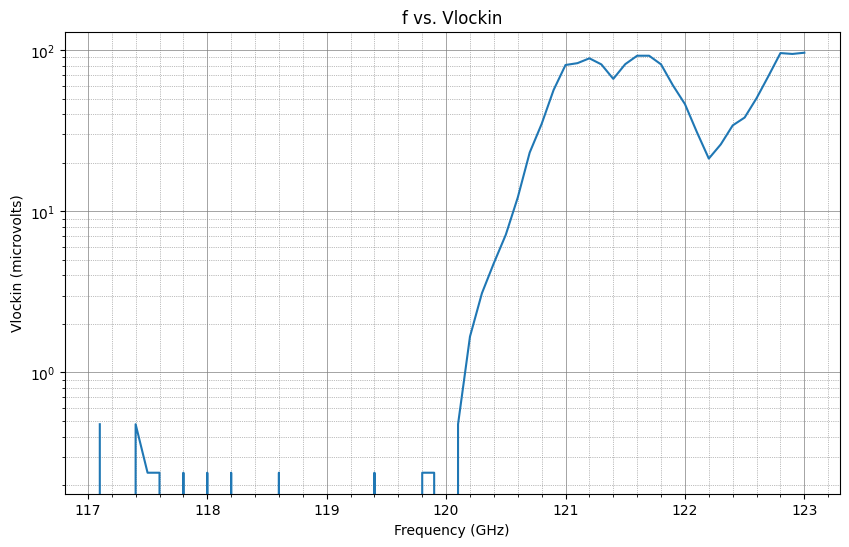

In [15]:
#Plot f vs. entered Vlockin with a log scale
plt.figure(figsize = (10, 6))
plt.plot(df['Desired Frequency (GHz)'], df['Vlockin (microvolts)'])
plt.yscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Vlockin (microvolts)')
plt.title('f vs. Vlockin')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
#save to png
plt.savefig(plot_file)
log_and_print(f"The data has been saved to {plot_file}, previous file may have been overwritten.")
#display the plot
plt.show()

In [16]:
#Either power down PROWLS and turn off bias amplitude, bias offset, and lasers, or keep them all on.
with Client(SerialConnection(dlc_connection_port)) as client:
    if power_down:
        client.set('lockin:mod-out-amplitude', 0)
        client.set('lockin:mod-out-offset', 0)
        #wait 5 secs for DLC smart to adjust
        time.sleep(5)
        client.set('laser-operation:emission-global-enable', False)
        log_and_print(f"PROWLS powered down")
    else:
        log_and_print(f"PROWLS did NOT power down")
    log_and_print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    log_and_print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    log_and_print(f'Lasers on: {client.get('laser-operation:emission-global-enable')}')

PROWLS did NOT power down
Current DLC Smart Bias Amplitude (V): 0.800018310546875
Current DLC Smart Bias Offset (V): -0.30002441704309607
Lasers on: True
